In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
holidays = pd.read_csv("holidays_events.csv")

In [5]:
# Convert date columns to datetime format
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])
oil["date"] = pd.to_datetime(oil["date"])
holidays["date"] = pd.to_datetime(holidays["date"])

In [7]:
# Handle missing values in oil prices using interpolation
oil["dcoilwtico"] = oil["dcoilwtico"].interpolate()

In [9]:
# Merge additional datasets with train and test data
train = train.merge(stores, on="store_nbr", how="left")
train = train.merge(oil, on="date", how="left")
train = train.merge(holidays, on="date", how="left")

test = test.merge(stores, on="store_nbr", how="left")
test = test.merge(oil, on="date", how="left")
test = test.merge(holidays, on="date", how="left")

In [11]:
# # Display dataset info after merging
print(train.shape)
print(test.shape)

(3054348, 16)
(28512, 15)


In [13]:
## Time-based Features
train["day"] = train["date"].dt.day
train["week"] = train["date"].dt.isocalendar().week
train["month"] = train["date"].dt.month
train["year"] = train["date"].dt.year
train["day_of_week"] = train["date"].dt.dayofweek
train["is_december"] = (train["month"] == 12).astype(int)

test["day"] = test["date"].dt.day
test["week"] = test["date"].dt.isocalendar().week
test["month"] = test["date"].dt.month
test["year"] = test["date"].dt.year
test["day_of_week"] = test["date"].dt.dayofweek
test["is_december"] = (test["month"] == 12).astype(int)

In [15]:
## Event-based Features
train["is_holiday"] = train["type_y"].notnull().astype(int)
test["is_holiday"] = test["type_y"].notnull().astype(int)

train["is_payday"] = ((train["day"] == 15) | (train["day"] == train["date"].dt.days_in_month)).astype(int)
test["is_payday"] = ((test["day"] == 15) | (test["day"] == test["date"].dt.days_in_month)).astype(int)

train["earthquake_impact"] = (train["date"] == "2016-04-16").astype(int)
test["earthquake_impact"] = (test["date"] == "2016-04-16").astype(int)

In [17]:
## Rolling Statistics
train.sort_values(by=["store_nbr", "family", "date"], inplace=True)
test.sort_values(by=["store_nbr", "family", "date"], inplace=True)

train["sales_7d_avg"] = train.groupby(["store_nbr", "family"])['sales'].transform(lambda x: x.rolling(7, min_periods=1).mean())
train["sales_7d_std"] = train.groupby(["store_nbr", "family"])['sales'].transform(lambda x: x.rolling(7, min_periods=1).std())
train["sales_lag_7"] = train.groupby(["store_nbr", "family"])['sales'].shift(7)
train["sales_lag_30"] = train.groupby(["store_nbr", "family"])['sales'].shift(30)

In [19]:
## Store-Specific Aggregations
store_avg_sales = train.groupby("store_nbr")["sales"].mean().rename("store_avg_sales")
train = train.merge(store_avg_sales, on="store_nbr", how="left")
test = test.merge(store_avg_sales, on="store_nbr", how="left")

top_selling_families = train.groupby("family")["sales"].sum().sort_values(ascending=False).head(10).index
train["is_top_family"] = train["family"].isin(top_selling_families).astype(int)
test["is_top_family"] = test["family"].isin(top_selling_families).astype(int)

# Exploratory Data Analysis (EDA)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

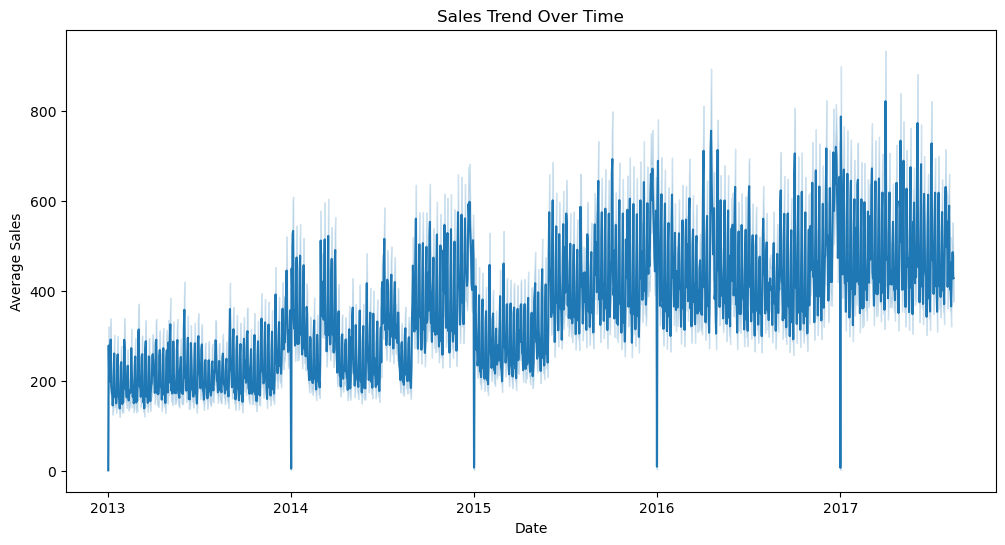

In [24]:
## Visualizing sales trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=train, x="date", y="sales", estimator="mean")
plt.title("Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Average Sales")
plt.show()

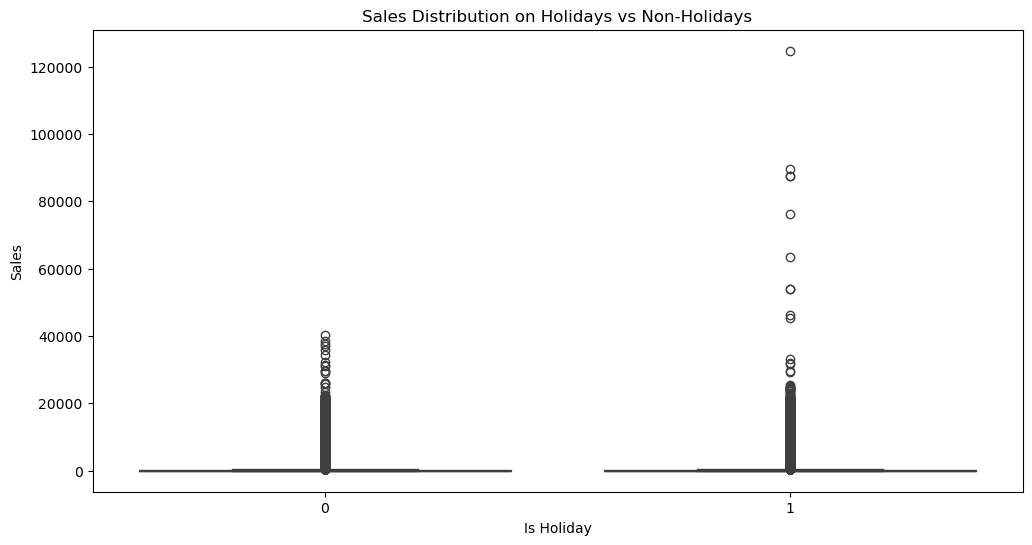

In [26]:
## Sales before and after holidays and promotions
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x="is_holiday", y="sales")
plt.title("Sales Distribution on Holidays vs Non-Holidays")
plt.xlabel("Is Holiday")
plt.ylabel("Sales")
plt.show()

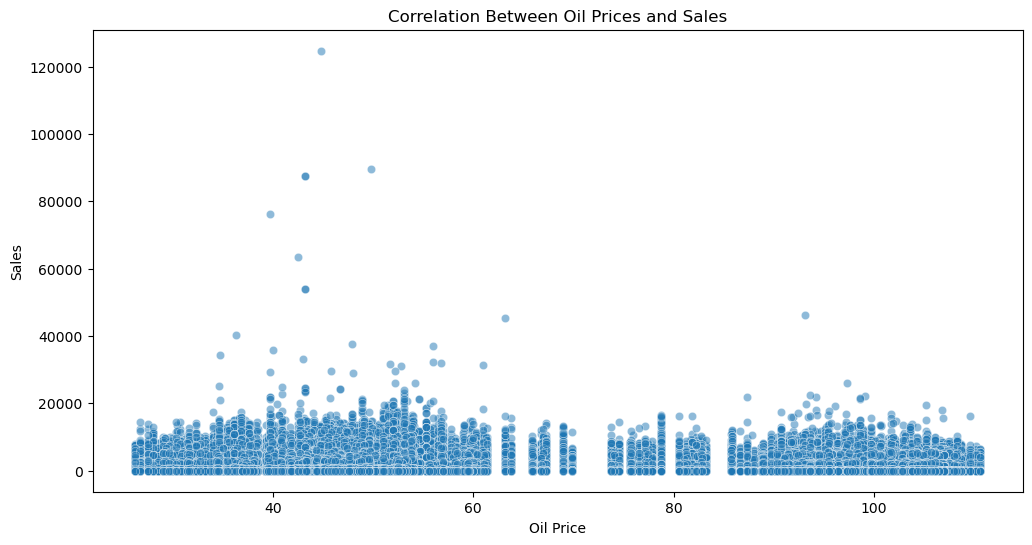

In [28]:
## Correlation between oil prices and sales trends
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train, x="dcoilwtico", y="sales", alpha=0.5)
plt.title("Correlation Between Oil Prices and Sales")
plt.xlabel("Oil Price")
plt.ylabel("Sales")
plt.show()

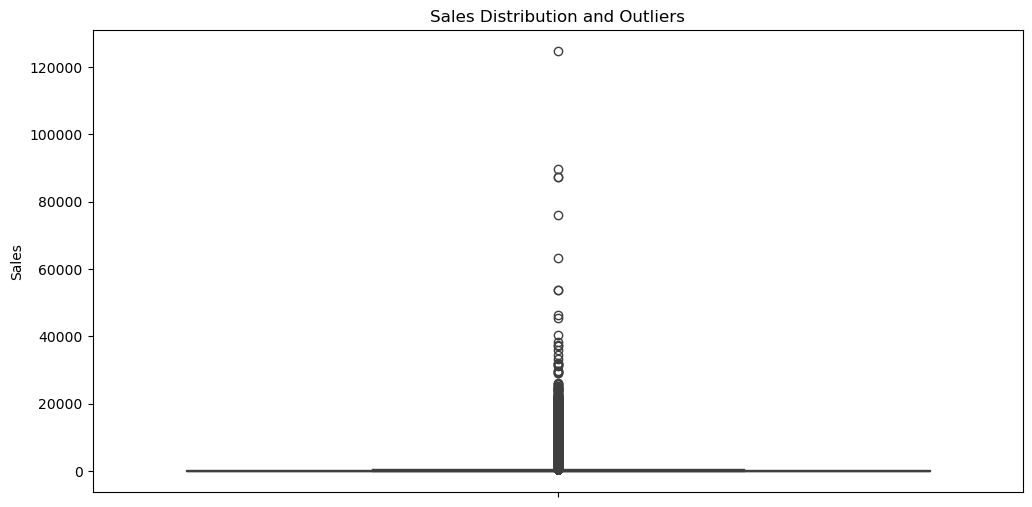

In [30]:
## Identifying anomalies in sales data
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, y="sales")
plt.title("Sales Distribution and Outliers")
plt.ylabel("Sales")
plt.show()

# Preprocessing

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [35]:
## Encode categorical features
label_encoders = {}
categorical_columns = ["family", "city", "state", "type_x","type_y",]
for col in categorical_columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

In [37]:
## Drop unnecessary columns
train.drop(columns=["date","id","locale","locale_name","description","transferred"], inplace=True)
test.drop(columns=["date","id","locale","locale_name","description","transferred"], inplace=True)

In [39]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [41]:
train_subset = train.iloc[-500000:]

In [43]:
## Splitting train data into training and validation sets
X = train_subset.drop(columns=["sales"])
y = train_subset["sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Building

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [48]:
import numpy as np

In [50]:
# Define evaluation function
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}")
    print(f"R2 Score: {r2}\n")
    return rmse, mape, r2

In [52]:
### Baseline Model (Naïve Forecasting) ###
# Ensure y_val and y_train have matching indices
y_pred_naive = np.roll(y_train, shift=1)[-len(y_test):]  # Shift last values forward
y_pred_naive[0] = y_train.iloc[-1]  # Use last known sales value for first prediction

# Evaluate model
rmse_naive, mape_naive, r2_naive = evaluate_model(y_test, y_pred_naive, "Naïve Forecasting")

Naïve Forecasting Performance:
RMSE: 2112.7687548034746
MAPE: 7.514116421766445e+17
R2 Score: -1.0012096734610951



In [54]:
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [56]:
from statsmodels.tsa.arima.model import ARIMA

In [58]:
### ARIMA Model ###
model_arima = ARIMA(y_train, order=(2,1,0))
model_arima_fit = model_arima.fit()
y_pred_arima = model_arima_fit.forecast(steps=len(y_test))
rmse_arima, mape_arima, r2_arima = evaluate_model(y_test, y_pred_arima, "ARIMA")

ARIMA Performance:
RMSE: 1513.9596784198493
MAPE: 3.889276080367503e+17
R2 Score: -0.027583872755030603



In [60]:
from sklearn.ensemble import RandomForestRegressor

In [62]:
### Random Forest Regressor ###
rf_model = RandomForestRegressor(n_estimators=1, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf, mape_rf, r2_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")

Random Forest Performance:
RMSE: 332.1001004659156
MAPE: 4205328408792237.5
R2 Score: 0.9505545109972318



In [64]:
from xgboost import XGBRegressor

In [66]:
### XGBoost Model ###
xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.1, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb, mape_xgb, r2_xgb = evaluate_model(y_test, y_pred_xgb, "XGBoost")

XGBoost Performance:
RMSE: 219.56846618652344
MAPE: 1.221464002920448e+16
R2 Score: 0.9783863425254822



In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [70]:
### LSTM Model ###

y_train = np.array(y_train)
y_test = np.array(y_test)

# Reshape to 2D for MinMaxScaler
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

# Reshape for LSTM input (samples, time steps, features)
X_train_lstm = np.reshape(y_train_scaled, (y_train_scaled.shape[0], 1, 1))
X_test_lstm = np.reshape(y_test_scaled, (y_test_scaled.shape[0], 1, 1))

# LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1,1)),
    Dropout(0.2),
    LSTM(50),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
lstm_model.fit(X_train_lstm, y_train_scaled, epochs=10, batch_size=32, verbose=1)

# Predict and inverse transform
y_pred_lstm = scaler.inverse_transform(lstm_model.predict(X_test_lstm))

# Evaluate Model (Ensure evaluate_model is defined)
rmse_lstm, mape_lstm, r2_lstm = evaluate_model(y_test, y_pred_lstm, "LSTM")

Epoch 1/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 1.6404e-04
Epoch 2/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step - loss: 1.9314e-05
Epoch 3/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - loss: 1.9364e-05
Epoch 4/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 1.9346e-05
Epoch 5/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 1.8934e-05
Epoch 6/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 1.8331e-05
Epoch 7/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 1.6290e-05
Epoch 8/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 1.4919e-05
Epoch 9/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 1.3650e-05
Epoch 10/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 1.2760e-05
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
LSTM Performance:
RMSE: 51.55891799926758
MAPE: 7.346630036134298e+16
R2 Score: 0.9988082051277161



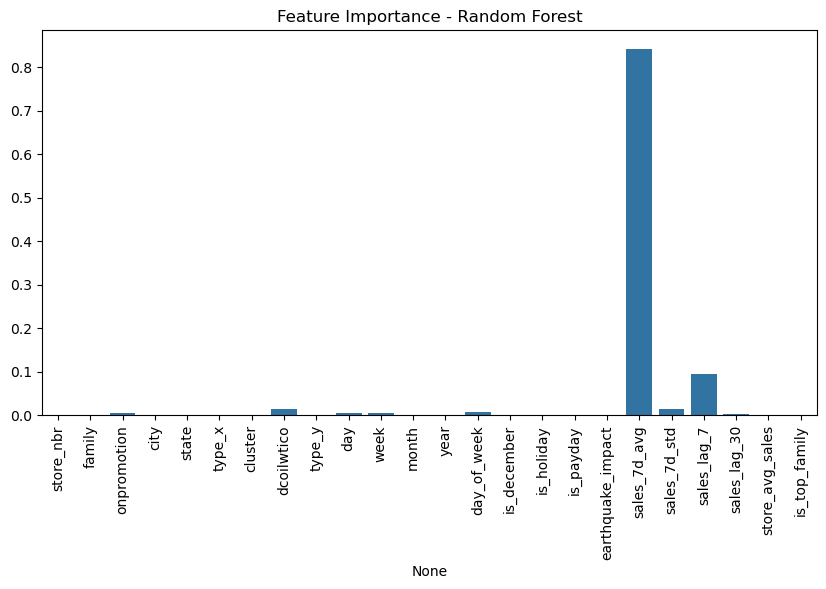

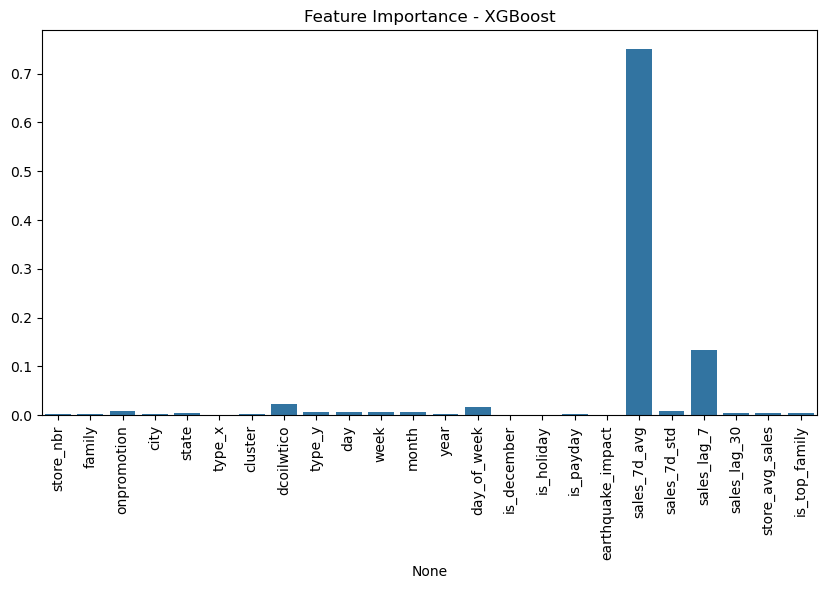

In [72]:
# Feature Importance (Random Forest & XGBoost)
plt.figure(figsize=(10,5))
sns.barplot(x=X_train.columns, y=rf_model.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature Importance - Random Forest")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x=X_train.columns, y=xgb_model.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature Importance - XGBoost")
plt.show()

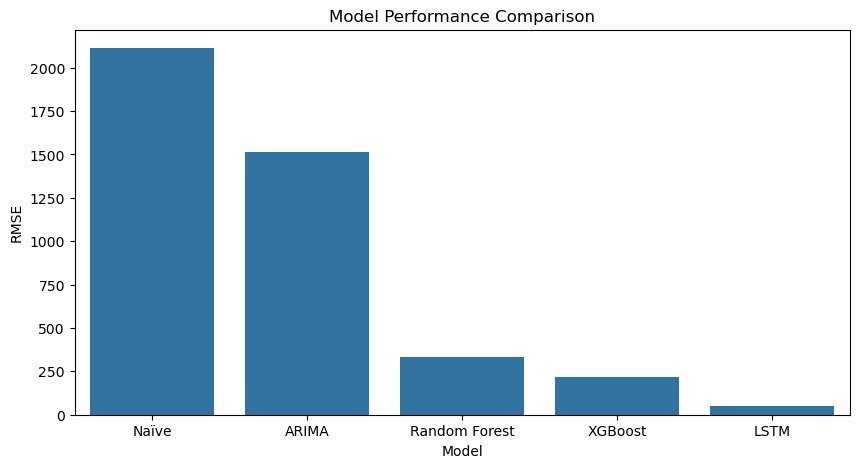

In [76]:
# Visualization
models = ["Naïve", "ARIMA", "Random Forest", "XGBoost", "LSTM",]
rmse_values = [rmse_naive, rmse_arima, rmse_rf, rmse_xgb, rmse_lstm]

plt.figure(figsize=(10,5))
sns.barplot(x=models, y=rmse_values)
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("Model Performance Comparison")
plt.show()